In [1]:
import pandas as pd
from tqdm import tqdm
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv('/home/maia-user/myl/sc/Datasets/processed_total.csv')
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0.750561,1.416667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,0.755108,1.333333e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [2]:
print(df.shape)
print(df["Label"].value_counts())

(2827876, 79)
Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [3]:

# 假设你已经加载好 df，并完成归一化，包含 "Label" 列
rare_classes = ["Infiltration", "Web Attack � XSS", "Web Attack � Sql Injection", "Heartbleed"]
# 固定 BENIGN 样本数（防止混淆 GAN 效果）
benign_df = df[df["Label"] == "BENIGN"].sample(n=100000, random_state=42)

In [4]:
rare_raw = df[df["Label"].isin(rare_classes)]
df_raw = pd.concat([benign_df, rare_raw], ignore_index=True)

In [5]:
from cgan_module import cgan_augment  # 你已经写好了！

df_single = cgan_augment(df, rare_classes, generate_per_class=500)
rare_single = df_single[df_single["Label"].isin(rare_classes)]
df_single_full = pd.concat([benign_df, rare_single], ignore_index=True)



🔍 正在增强类别: Infiltration
[0/500] Loss_D: 1.3794, Loss_G: 0.6800
[100/500] Loss_D: 0.9462, Loss_G: 1.0936
[200/500] Loss_D: 0.2750, Loss_G: 2.8985
[300/500] Loss_D: 0.2337, Loss_G: 3.0299
[400/500] Loss_D: 1.0625, Loss_G: 1.2860
✅ 生成完成: Infiltration → 500 条

🔍 正在增强类别: Web Attack � XSS
[0/500] Loss_D: 1.3974, Loss_G: 0.7025
[100/500] Loss_D: 0.8612, Loss_G: 1.4940
[200/500] Loss_D: 0.2221, Loss_G: 3.0684
[300/500] Loss_D: 0.9047, Loss_G: 1.0916
[400/500] Loss_D: 0.7611, Loss_G: 1.2903
✅ 生成完成: Web Attack � XSS → 500 条

🔍 正在增强类别: Web Attack � Sql Injection
[0/500] Loss_D: 1.4071, Loss_G: 0.6916
[100/500] Loss_D: 1.1653, Loss_G: 1.0027
[200/500] Loss_D: 0.3122, Loss_G: 2.6184
[300/500] Loss_D: 0.5447, Loss_G: 1.4910
[400/500] Loss_D: 0.9914, Loss_G: 1.1790
✅ 生成完成: Web Attack � Sql Injection → 500 条

🔍 正在增强类别: Heartbleed
[0/500] Loss_D: 1.4062, Loss_G: 0.6907
[100/500] Loss_D: 1.0094, Loss_G: 1.0769
[200/500] Loss_D: 0.2039, Loss_G: 2.8503
[300/500] Loss_D: 0.1333, Loss_G: 3.6713
[400/500] Lo

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def evaluate_pipeline(df_final, description):
    X = df_final.drop(columns=["Label"])
    y = df_final["Label"]

    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(f"\n📊 分类报告 ({description}):")
    print(classification_report(y_test, y_pred, digits=4))


In [7]:
evaluate_pipeline(df_raw, "A. 无增强 Baseline")
evaluate_pipeline(df_single_full, "B. 单类分别增强")


📊 分类报告 (A. 无增强 Baseline):
                            precision    recall  f1-score   support

                    BENIGN     0.9993    1.0000    0.9997     20000
                Heartbleed     1.0000    1.0000    1.0000         2
              Infiltration     1.0000    0.7143    0.8333         7
Web Attack � Sql Injection     0.0000    0.0000    0.0000         4
          Web Attack � XSS     1.0000    0.9389    0.9685       131

                  accuracy                         0.9993     20144
                 macro avg     0.7999    0.7306    0.7603     20144
              weighted avg     0.9991    0.9993    0.9992     20144



/home/maia-user/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maia-user/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/maia-user/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 分类报告 (B. 单类分别增强):
                            precision    recall  f1-score   support

                    BENIGN     0.9997    1.0000    0.9998     20000
                Heartbleed     1.0000    0.9902    0.9951       102
              Infiltration     1.0000    0.9720    0.9858       107
Web Attack � Sql Injection     1.0000    0.9904    0.9952       104
          Web Attack � XSS     0.9956    0.9870    0.9913       231

                  accuracy                         0.9996     20544
                 macro avg     0.9991    0.9879    0.9934     20544
              weighted avg     0.9996    0.9996    0.9996     20544



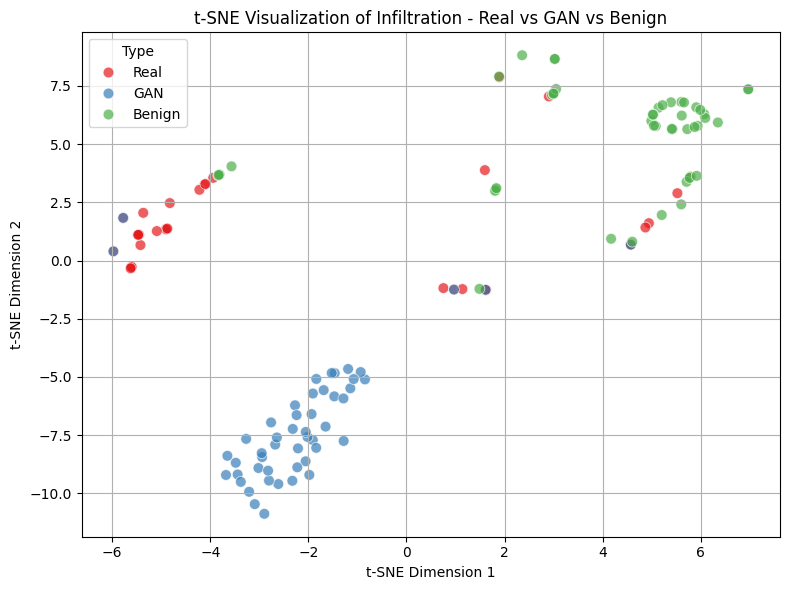

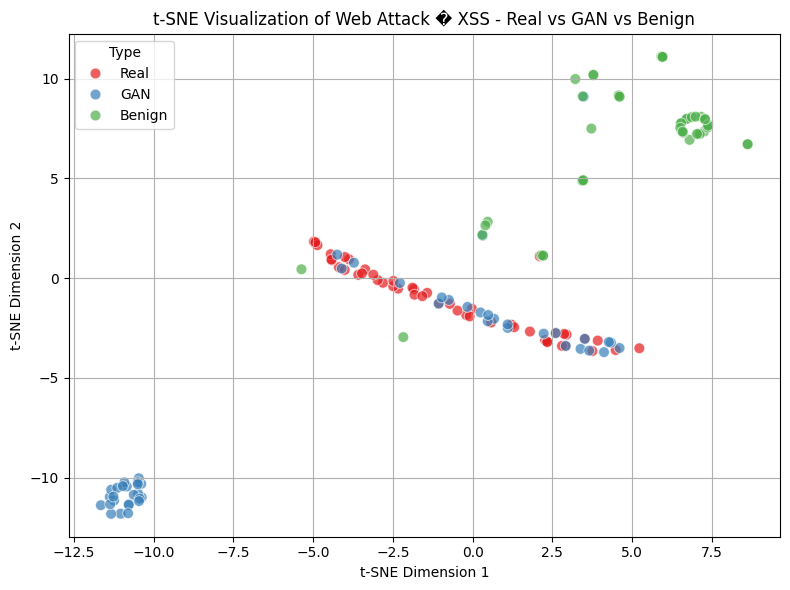

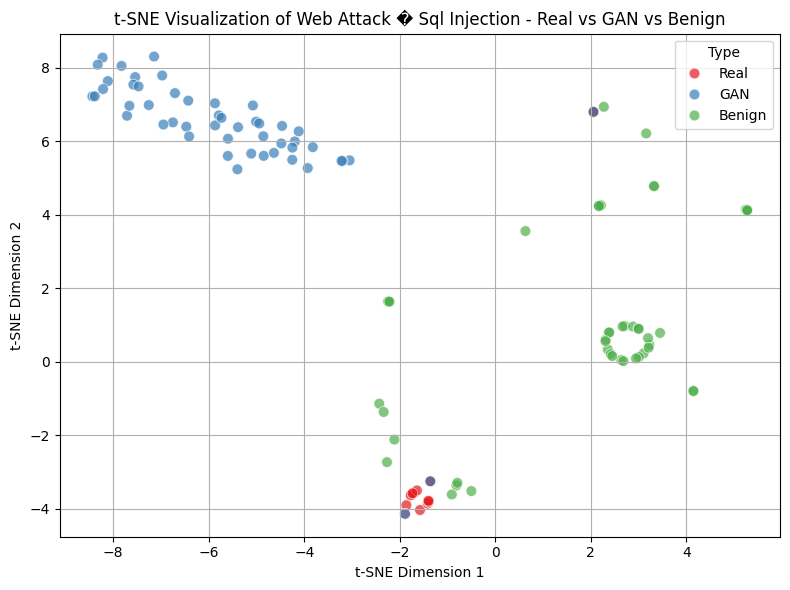

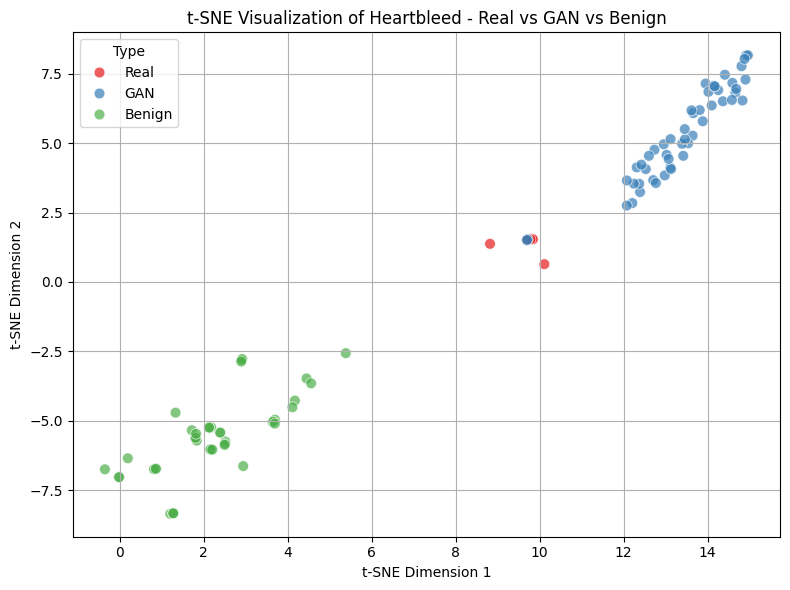

In [14]:
from visualization import plot_tsne_distribution

for a in rare_classes:
    # 按照类别筛选对应的真实样本和 GAN 样本
    real_a = rare_raw[rare_raw["Label"] == a]
    fake_a = rare_single[rare_single["Label"] == a]

    if len(real_a) < 5 or len(fake_a) < 5:
        print(f"⚠️ 样本过少，跳过类别: {a}")
        continue

    # 画出该类别的 t-SNE 图
    plot_tsne_distribution(
        benign_df=benign_df,
        rare_raw=real_a,
        rare_single=fake_a,
        label=a,
        sample_size=50  # 可以调成较小值，避免少样本画不出图
    )

